**INSTALL DEPENDENCIES**

In [ ]:
!pip install wfdb scipy scikit-learn torch torchvision einops pandas matplotlib seaborn tqdm -q

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt, find_peaks, resample
from scipy.stats import pearsonr
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import wfdb
from einops import rearrange
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("="*70)
print(f"🚀 SYSTEM CONFIGURATION")
print("="*70)
print(f"✓ Device: {device}")
print(f"✓ CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✓ CUDA Version: {torch.version.cuda}")
print(f"✓ PyTorch Version: {torch.__version__}")
print("="*70)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 53.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
🚀 SYSTEM CONFIGURATION
✓ Device: cpu
✓ CUDA Available: False
✓ PyTorch Version: 2.9.0+cpu


**DOWNLOAD PHYSIONET DATASET**

In [ ]:
import urllib.request
import subprocess

print("\n📥 DOWNLOADING PHYSIONET PPG DATASET")
print("="*70)

# Create data directory
os.makedirs("ppg_data", exist_ok=True)
os.chdir("ppg_data")

# Download RECORDS file
print("⏳ Downloading dataset index...")
try:
    urllib.request.urlretrieve(
        "https://physionet.org/files/pulse-transit-time-ppg/1.1.0/RECORDS",
        "RECORDS"
    )
    print("✓ Dataset index downloaded")
except Exception as e:
    print(f"✗ Error: {e}")
    sys.exit(1)

# Read record names
with open("RECORDS", "r") as f:
    all_records = [line.strip() for line in f.readlines() if line.strip()]

print(f"✓ Found {len(all_records)} total records in database")

# Download subset of records
NUM_RECORDS = 30  # Adjust based on your needs
base_url = "https://physionet.org/files/pulse-transit-time-ppg/1.1.0"
records_to_download = all_records[:NUM_RECORDS]

print(f"⏳ Downloading {NUM_RECORDS} records (this may take a few minutes)...\n")

downloaded = 0
for i, rec in enumerate(records_to_download):
    try:
        for ext in [".dat", ".hea"]:
            url = f"{base_url}/{rec}{ext}"
            urllib.request.urlretrieve(url, f"{rec}{ext}")
        downloaded += 1
        if (i + 1) % 5 == 0:
            print(f"  Progress: {i+1}/{NUM_RECORDS} records")
    except Exception as e:
        print(f"  ⚠ Failed to download {rec}: {e}")

print(f"\n✓ Successfully downloaded {downloaded} records")
print("="*70)



📥 DOWNLOADING PHYSIONET PPG DATASET
⏳ Downloading dataset index...
✓ Dataset index downloaded
✓ Found 66 total records in database
⏳ Downloading 30 records (this may take a few minutes)...

  Progress: 5/30 records
  Progress: 10/30 records
  Progress: 15/30 records
  Progress: 20/30 records
  Progress: 25/30 records
  Progress: 30/30 records

✓ Successfully downloaded 30 records


**LOAD AND VALIDATE DATA**

In [ ]:
print("\n📂 LOADING PPG DATA FROM RECORDS")
print("="*70)

def load_ppg_dataset():
    """Load all PPG records with validation"""

    # Find downloaded records
    files = os.listdir('.')
    record_names = sorted(list(set([
        f.replace('.dat', '').replace('.hea', '')
        for f in files if f.endswith(('.dat', '.hea'))
    ])))

    data_collection = []

    for idx, rec_name in enumerate(record_names):
        try:
            # Read record
            record = wfdb.rdrecord(rec_name)
            fs = record.fs
            sig_names = record.sig_name

            # Find PPG channel
            ppg_idx = None
            for i, name in enumerate(sig_names):
                if 'PPG' in name.upper() or 'PLETH' in name.upper():
                    ppg_idx = i
                    break

            if ppg_idx is None:
                print(f"  ⚠ {rec_name}: No PPG signal found")
                continue

            # Extract PPG
            ppg = record.p_signal[:, ppg_idx].astype(np.float32)

            # Validate minimum length (30 seconds)
            if len(ppg) / fs < 30:
                print(f"  ⚠ {rec_name}: Too short ({len(ppg)/fs:.1f}s)")
                continue

            data_collection.append({
                'name': rec_name,
                'ppg': ppg,
                'fs': fs,
                'duration': len(ppg) / fs
            })

            print(f"  ✓ [{idx+1:2d}] {rec_name:20s} | FS: {fs:3.0f} Hz | Duration: {len(ppg)/fs:6.1f}s | Samples: {len(ppg):,}")

        except Exception as e:
            print(f"  ✗ {rec_name}: Error - {str(e)}")

    return data_collection

# Load data
data_records = load_ppg_dataset()
print(f"\n✓ Successfully loaded {len(data_records)} valid records")
print("="*70)

if len(data_records) == 0:
    print("❌ No valid records loaded. Please check the download.")
    sys.exit(1)


📂 LOADING PPG DATA FROM RECORDS
  ✓ [ 1] s10_run              | FS: 500 Hz | Duration:  485.6s | Samples: 242,815
  ✓ [ 2] s10_sit              | FS: 500 Hz | Duration:  485.7s | Samples: 242,843
  ✓ [ 3] s10_walk             | FS: 500 Hz | Duration:  485.7s | Samples: 242,859
  ✓ [ 4] s1_run               | FS: 500 Hz | Duration:  490.5s | Samples: 245,274
  ✓ [ 5] s1_sit               | FS: 500 Hz | Duration:  508.1s | Samples: 254,026
  ✓ [ 6] s1_walk              | FS: 500 Hz | Duration:  491.8s | Samples: 245,902
  ✓ [ 7] s2_run               | FS: 500 Hz | Duration:  493.2s | Samples: 246,578
  ✓ [ 8] s2_sit               | FS: 500 Hz | Duration:  492.4s | Samples: 246,206
  ✓ [ 9] s2_walk              | FS: 500 Hz | Duration:  493.7s | Samples: 246,864
  ✓ [10] s3_run               | FS: 500 Hz | Duration:  487.5s | Samples: 243,727
  ✓ [11] s3_sit               | FS: 500 Hz | Duration:  492.3s | Samples: 246,149
  ✓ [12] s3_walk              | FS: 500 Hz | Duration:  493.2s | 

**SIGNAL PREPROCESSING PIPELINE**


🔧 SIGNAL PREPROCESSING PIPELINE


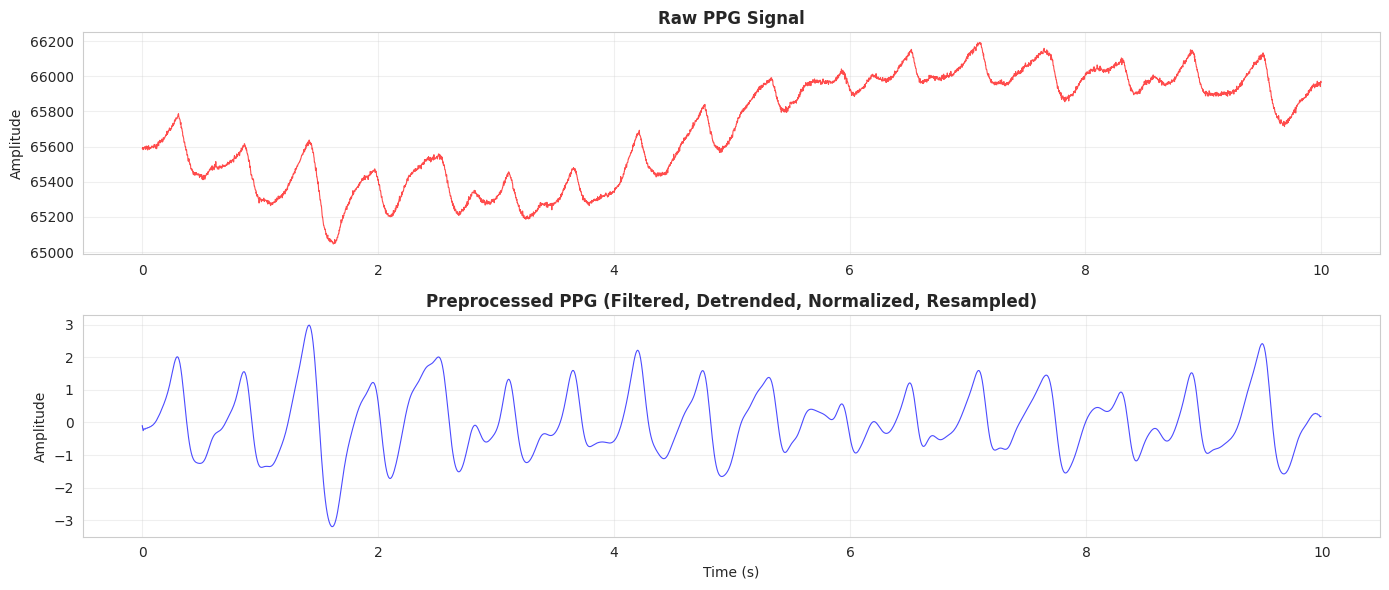

✓ Preprocessing pipeline ready


In [ ]:
print("\n🔧 SIGNAL PREPROCESSING PIPELINE")
print("="*70)

class PPGPreprocessor:
    """Advanced PPG signal preprocessing"""

    def __init__(self, target_fs=125):
        self.target_fs = target_fs

    def bandpass_filter(self, signal, fs, lowcut=0.5, highcut=8.0, order=4):
        """Bandpass filter: 0.5-8 Hz (30-480 bpm)"""
        nyquist = 0.5 * fs
        low = max(0.001, min(lowcut / nyquist, 0.999))
        high = max(0.001, min(highcut / nyquist, 0.999))

        if low >= high:
            high = min(high + 0.01, 0.999)

        b, a = butter(order, [low, high], btype='band')
        return filtfilt(b, a, signal, padlen=min(50, len(signal)//3))

    def remove_outliers(self, signal, threshold=4):
        """Remove outliers using z-score"""
        mean, std = signal.mean(), signal.std()
        z_scores = np.abs((signal - mean) / (std + 1e-6))
        signal_clean = signal.copy()
        signal_clean[z_scores > threshold] = np.median(signal)
        return signal_clean

    def detrend(self, signal):
        """Polynomial detrending"""
        x = np.arange(len(signal))
        coeffs = np.polyfit(x, signal, 2)
        trend = np.polyval(coeffs, x)
        return signal - trend

    def resample_signal(self, signal, fs):
        """Resample to target frequency"""
        if fs == self.target_fs:
            return signal
        num_samples = int(len(signal) * self.target_fs / fs)
        return resample(signal, num_samples)

    def normalize(self, signal):
        """Z-score normalization"""
        mean, std = signal.mean(), signal.std()
        return (signal - mean) / (std + 1e-6)

    def process(self, signal, fs):
        """Complete preprocessing pipeline"""
        signal = self.bandpass_filter(signal, fs)
        signal = self.remove_outliers(signal)
        signal = self.detrend(signal)
        signal = self.resample_signal(signal, fs)
        signal = self.normalize(signal)
        return signal.astype(np.float32)

preprocessor = PPGPreprocessor(target_fs=125)

# Visualize preprocessing
sample_record = data_records[0]
ppg_raw = sample_record['ppg'][:int(sample_record['fs'] * 10)]  # 10 seconds
ppg_proc = preprocessor.process(ppg_raw.copy(), sample_record['fs'])

fig, axes = plt.subplots(2, 1, figsize=(14, 6))

time_raw = np.arange(len(ppg_raw)) / sample_record['fs']
time_proc = np.arange(len(ppg_proc)) / 125

axes[0].plot(time_raw, ppg_raw, 'r-', linewidth=0.8, alpha=0.7)
axes[0].set_title('Raw PPG Signal', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Amplitude')
axes[0].grid(True, alpha=0.3)

axes[1].plot(time_proc, ppg_proc, 'b-', linewidth=0.8, alpha=0.7)
axes[1].set_title('Preprocessed PPG (Filtered, Detrended, Normalized, Resampled)', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Amplitude')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Preprocessing pipeline ready")
print("="*70)

**HEART RATE LABEL EXTRACTION**


💓 HEART RATE LABEL GENERATION
⏳ Generating windowed dataset...

  ✓ s10_run             :  120 windows | HR: 102.5± 3.2 bpm | Range: [93, 110]
  ✓ s10_sit             :  120 windows | HR:  74.6± 5.3 bpm | Range: [65, 88]
  ✓ s10_walk            :  120 windows | HR: 101.5±10.1 bpm | Range: [71, 123]
  ✓ s1_run              :  121 windows | HR:  89.4± 9.0 bpm | Range: [68, 130]
  ✓ s1_sit              :  126 windows | HR:  72.4± 3.1 bpm | Range: [65, 82]
  ✓ s1_walk             :  121 windows | HR:  96.3± 4.0 bpm | Range: [88, 109]
  ✓ s2_run              :  122 windows | HR: 122.4± 4.4 bpm | Range: [107, 131]
  ✓ s2_sit              :  122 windows | HR: 120.8± 3.6 bpm | Range: [111, 128]
  ✓ s2_walk             :  122 windows | HR: 116.2±10.0 bpm | Range: [85, 134]
  ✓ s3_run              :  120 windows | HR:  87.9± 5.2 bpm | Range: [73, 110]
  ✓ s3_sit              :  122 windows | HR:  74.5± 4.7 bpm | Range: [61, 84]
  ✓ s3_walk             :  122 windows | HR:  87.1± 3.8 bpm | Range

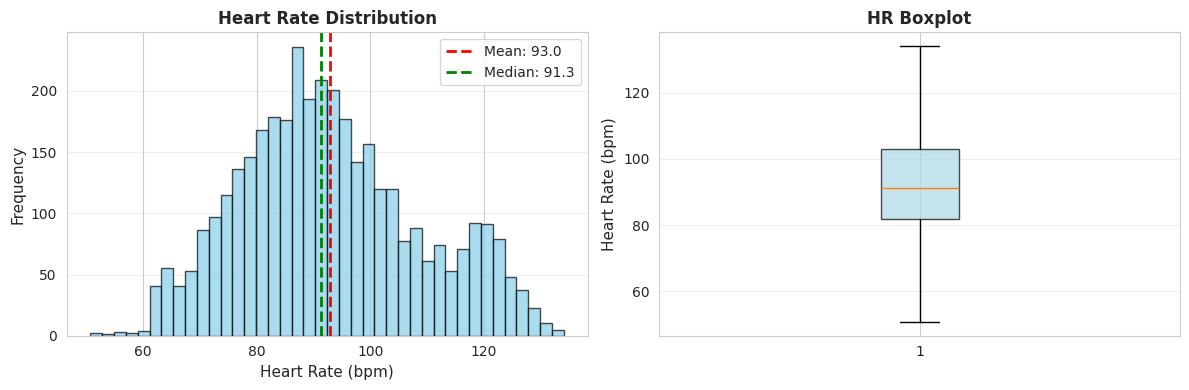

In [ ]:

print("\n💓 HEART RATE LABEL GENERATION")
print("="*70)

def calculate_hr_from_ppg(ppg_segment, fs):
    """Calculate heart rate from PPG using peak detection"""

    # Peak detection parameters
    min_distance = int(fs * 60 / 180)  # Max 180 bpm

    try:
        peaks, _ = find_peaks(ppg_segment, distance=min_distance, prominence=0.3)

        if len(peaks) < 2:
            return None

        # Calculate inter-beat intervals
        intervals_sec = np.diff(peaks) / fs
        hr = 60.0 / np.mean(intervals_sec)

        # Validate physiological range
        if 40 <= hr <= 180:
            return hr
        return None

    except:
        return None

def signal_quality_index(signal):
    """Calculate signal quality score"""
    # Based on energy and kurtosis
    energy = np.sqrt(np.mean(signal**2))
    kurtosis = np.mean((signal - signal.mean())**4) / (np.std(signal)**4 + 1e-6)

    # Good quality: moderate kurtosis, sufficient energy
    quality = energy if 1 < kurtosis < 8 else energy * 0.3
    return quality

def create_dataset_windows(ppg, fs, window_sec=8.0, stride_sec=4.0):
    """Create sliding windows with HR labels"""

    window_samples = int(window_sec * fs)
    stride_samples = int(stride_sec * fs)

    X_windows = []
    y_labels = []
    qualities = []

    for start in range(0, len(ppg) - window_samples, stride_samples):
        segment = ppg[start:start + window_samples]

        # Calculate HR
        hr = calculate_hr_from_ppg(segment, fs)
        if hr is None:
            continue

        # Check quality
        quality = signal_quality_index(segment)
        if quality < 0.05:
            continue

        # Per-window normalization
        seg_norm = (segment - segment.mean()) / (segment.std() + 1e-6)

        X_windows.append(seg_norm.astype(np.float32))
        y_labels.append(np.float32(hr))
        qualities.append(quality)

    return np.array(X_windows), np.array(y_labels), np.array(qualities)

# Generate dataset
print("⏳ Generating windowed dataset...\n")

all_X, all_y, all_q = [], [], []
stats = []

for idx, rec in enumerate(data_records):
    ppg_raw = rec['ppg']
    fs = rec['fs']
    name = rec['name']

    # Preprocess
    ppg_proc = preprocessor.process(ppg_raw.copy(), fs)

    # Create windows
    X, y, q = create_dataset_windows(ppg_proc, 125, window_sec=8.0, stride_sec=4.0)

    if len(X) > 0:
        all_X.append(X)
        all_y.append(y)
        all_q.append(q)

        stats.append({
            'record': name,
            'windows': len(X),
            'hr_mean': y.mean(),
            'hr_std': y.std(),
            'hr_min': y.min(),
            'hr_max': y.max()
        })

        print(f"  ✓ {name:20s}: {len(X):4d} windows | HR: {y.mean():5.1f}±{y.std():4.1f} bpm | Range: [{y.min():.0f}, {y.max():.0f}]")

# Concatenate
X_all = np.concatenate(all_X, axis=0)
y_all = np.concatenate(all_y, axis=0)
q_all = np.concatenate(all_q, axis=0)

print(f"\n{'='*70}")
print(f"📊 DATASET STATISTICS")
print(f"{'='*70}")
print(f"  Total windows:     {len(X_all):,}")
print(f"  Window shape:      {X_all.shape}")
print(f"  HR range:          {y_all.min():.1f} - {y_all.max():.1f} bpm")
print(f"  HR mean ± std:     {y_all.mean():.1f} ± {y_all.std():.1f} bpm")
print(f"  Median HR:         {np.median(y_all):.1f} bpm")
print(f"  Quality mean:      {q_all.mean():.3f}")
print(f"{'='*70}")

# Visualize HR distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(y_all, bins=40, edgecolor='black', alpha=0.7, color='skyblue')
plt.axvline(y_all.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {y_all.mean():.1f}')
plt.axvline(np.median(y_all), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(y_all):.1f}')
plt.xlabel('Heart Rate (bpm)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Heart Rate Distribution', fontweight='bold', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

plt.subplot(1, 2, 2)
plt.boxplot(y_all, vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightblue', alpha=0.7))
plt.ylabel('Heart Rate (bpm)', fontsize=11)
plt.title('HR Boxplot', fontweight='bold', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


**TRAIN/VALIDATION/TEST SPLIT**

In [ ]:
from sklearn.model_selection import train_test_split

print("\n📊 CREATING TRAIN/VAL/TEST SPLITS")
print("="*70)

# Stratified split by HR bins
hr_bins = pd.cut(y_all, bins=[0, 60, 75, 90, 105, 200], labels=False)

# 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all, test_size=0.3, random_state=42, stratify=hr_bins
)

hr_bins_temp = pd.cut(y_temp, bins=[0, 60, 75, 90, 105, 200], labels=False)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=hr_bins_temp
)

print(f"  Train set: {X_train.shape[0]:5,} samples | HR: {y_train.mean():.1f} ± {y_train.std():.1f} bpm")
print(f"  Val set:   {X_val.shape[0]:5,} samples | HR: {y_val.mean():.1f} ± {y_val.std():.1f} bpm")
print(f"  Test set:  {X_test.shape[0]:5,} samples | HR: {y_test.mean():.1f} ± {y_test.std():.1f} bpm")
print("="*70)




📊 CREATING TRAIN/VAL/TEST SPLITS
  Train set: 2,568 samples | HR: 93.1 ± 15.9 bpm
  Val set:     550 samples | HR: 92.7 ± 15.7 bpm
  Test set:    551 samples | HR: 92.9 ± 16.0 bpm


**PYTORCH DATASET & DATALOADER**

In [ ]:
class PPGDataset(Dataset):
    """PyTorch dataset for PPG signals"""

    def __init__(self, X, y, augment=False):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
        self.augment = augment

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx].unsqueeze(0)  # Shape: (1, seq_len)
        y = self.y[idx]

        if self.augment and torch.rand(1).item() < 0.5:
            # Add Gaussian noise
            x = x + torch.randn_like(x) * 0.02
            # Random scaling
            x = x * (0.95 + torch.rand(1) * 0.1)

        return x, y

# Create datasets and dataloaders
batch_size = 32

train_dataset = PPGDataset(X_train, y_train, augment=True)
val_dataset = PPGDataset(X_val, y_val, augment=False)
test_dataset = PPGDataset(X_test, y_test, augment=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=2, pin_memory=True)

print(f"\n✓ Created dataloaders with batch size {batch_size}")


✓ Created dataloaders with batch size 32


**VISION TRANSFORMER MODEL**

In [ ]:
print("\n🧠 BUILDING VISION TRANSFORMER MODEL")
print("="*70)

class PatchEmbedding1D(nn.Module):
    """1D Patch Embedding for time series"""

    def __init__(self, seq_len, patch_len, embed_dim):
        super().__init__()
        self.num_patches = seq_len // patch_len
        self.patch_len = patch_len
        self.projection = nn.Linear(patch_len, embed_dim)

    def forward(self, x):
        # x: (B, 1, seq_len) -> (B, seq_len)
        x = x.squeeze(1)
        # Reshape to patches: (B, num_patches, patch_len)
        x = x.unfold(1, self.patch_len, self.patch_len)
        # Project: (B, num_patches, embed_dim)
        x = self.projection(x)
        return x

class ViT1D(nn.Module):
    """Vision Transformer for 1D PPG signals"""

    def __init__(self, seq_len=1000, patch_len=25, embed_dim=128,
                 num_heads=8, num_layers=6, mlp_dim=256, dropout=0.1):
        super().__init__()

        # Patch embedding
        self.patch_embed = PatchEmbedding1D(seq_len, patch_len, embed_dim)
        num_patches = seq_len // patch_len

        # Learnable CLS token and positional embeddings
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
        self.dropout = nn.Dropout(dropout)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=mlp_dim,
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)

        # Regression head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Sequential(
            nn.Linear(embed_dim, 64),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

        self._init_weights()

    def _init_weights(self):
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, x):
        B = x.shape[0]

        # Patch embedding: (B, num_patches, embed_dim)
        x = self.patch_embed(x)

        # Add CLS token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)

        # Add positional embedding
        x = x + self.pos_embed
        x = self.dropout(x)

        # Transformer encoding
        x = self.transformer(x)

        # Use CLS token for prediction
        x = x[:, 0]
        x = self.norm(x)

        # Regression head
        x = self.head(x)
        return x.squeeze(-1)

# Initialize model
seq_len = X_train.shape[1]  # 1000 samples (8s * 125Hz)
model = ViT1D(
    seq_len=seq_len,
    patch_len=25,      # 40 patches
    embed_dim=128,
    num_heads=8,
    num_layers=6,
    mlp_dim=256,
    dropout=0.1
).to(device)

# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"  Model: Vision Transformer 1D")
print(f"  Input shape: (batch, 1, {seq_len})")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Embedding dim: 128")
print(f"  Number of patches: {seq_len // 25}")
print(f"  Transformer layers: 6")
print("="*70)



🧠 BUILDING VISION TRANSFORMER MODEL
  Model: Vision Transformer 1D
  Input shape: (batch, 1, 1000)
  Total parameters: 812,161
  Trainable parameters: 812,161
  Embedding dim: 128
  Number of patches: 40
  Transformer layers: 6


**TRAINING LOOP**

In [ ]:
print("\n🚀 TRAINING MODEL")
print("="*70)

# Training configuration
criterion = nn.HuberLoss(delta=5.0)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                                                  patience=5)
scaler = GradScaler()

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'val_mae': [],
    'val_rmse': []
}

def train_epoch(model, loader, criterion, optimizer, scaler, device):
    """Train one epoch"""
    model.train()
    total_loss = 0

    pbar = tqdm(loader, desc='Training', leave=False)
    for x, y in pbar:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        with autocast():
            pred = model(x)
            loss = criterion(pred, y)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * len(x)
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / len(loader.dataset)

def validate(model, loader, criterion, device):
    """Validate model"""
    model.eval()
    total_loss = 0
    preds, trues = [], []

    with torch.no_grad():
        for x, y in tqdm(loader, desc='Validating', leave=False):
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)

            total_loss += loss.item() * len(x)
            preds.append(pred.cpu().numpy())
            trues.append(y.cpu().numpy())

    preds = np.concatenate(preds)
    trues = np.concatenate(trues)

    mae = np.mean(np.abs(preds - trues))
    rmse = np.sqrt(np.mean((preds - trues)**2))

    return total_loss / len(loader.dataset), mae, rmse, preds, trues

# Training loop
num_epochs = 50
best_val_mae = float('inf')
patience = 10
patience_counter = 0


print(f"Training for {num_epochs} epochs...\n")

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, scaler, device)
    val_loss, val_mae, val_rmse, val_preds, val_trues = validate(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_mae'].append(val_mae)
    history['val_rmse'].append(val_rmse)

    scheduler.step(val_mae)

    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val MAE: {val_mae:.2f} bpm | "
              f"Val RMSE: {val_rmse:.2f} bpm")

    # Save best model
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save(model.state_dict(), 'best_vit_ppg_model.pt')
        patience_counter = 0
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= patience:
        print(f"\n⚠ Early stopping triggered at epoch {epoch+1}")
        break

print(f"\n✓ Training completed!")
print(f"✓ Best validation MAE: {best_val_mae:.2f} bpm")
print("="*70)



🚀 TRAINING MODEL
Training for 50 epochs...



Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d8dd5f6c9a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d8dd5f6c9a0>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

    Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

     self._shutdown_workers()   
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      ^if w.is_alive():^^
^ ^  ^ ^ ^  ^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^ ^ ^ ^^ 
    File "/usr/lib/

Epoch   1/50 | Train Loss: 434.6534 | Val Loss: 423.0015 | Val MAE: 87.10 bpm | Val RMSE: 88.51 bpm


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch   5/50 | Train Loss: 353.6411 | Val Loss: 337.3476 | Val MAE: 69.97 bpm | Val RMSE: 71.71 bpm


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d8dd5f6c9a0>Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    Exception ignored in: self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d8dd5f6c9a0>    if w.is_alive():

Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      ^if w.is_alive():^
^ ^  ^  ^ ^ ^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^ 
   File "/usr/lib/pyth

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  10/50 | Train Loss: 181.1617 | Val Loss: 154.7660 | Val MAE: 33.45 bpm | Val RMSE: 36.94 bpm


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d8dd5f6c9a0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d8dd5f6c9a0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        self._shutdown_workers()
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():if w.is_alive():

           ^ ^ ^ ^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^

   File "/usr/lib/pytho

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  15/50 | Train Loss: 33.4689 | Val Loss: 23.4985 | Val MAE: 6.66 bpm | Val RMSE: 9.35 bpm


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  20/50 | Train Loss: 25.3715 | Val Loss: 18.6935 | Val MAE: 5.69 bpm | Val RMSE: 7.89 bpm


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d8dd5f6c9a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d8dd5f6c9a0>
    Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
self._shutdown_workers()
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
self._shutdown_workers()    if w.is_alive():
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

      if w.is_alive(): 
         ^ ^ ^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^
assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python

Epoch  25/50 | Train Loss: 23.6153 | Val Loss: 16.8529 | Val MAE: 5.18 bpm | Val RMSE: 7.40 bpm


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  30/50 | Train Loss: 22.4156 | Val Loss: 15.9831 | Val MAE: 5.00 bpm | Val RMSE: 7.17 bpm


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d8dd5f6c9a0><function _MultiProcessingDataLoaderIter.__del__ at 0x7d8dd5f6c9a0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        self._shutdown_workers()
self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        if w.is_alive():
if w.is_alive(): 
            ^ ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^
    assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  35/50 | Train Loss: 22.2774 | Val Loss: 16.6912 | Val MAE: 5.23 bpm | Val RMSE: 7.29 bpm


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d8dd5f6c9a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d8dd5f6c9a0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
     self._shutdown_workers() 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       if w.is_alive(): 
 ^^ ^ ^ ^^^ ^^  ^ ^^^^^
^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^^
 ^ ^   ^   ^ 
    File "/usr

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  40/50 | Train Loss: 21.6993 | Val Loss: 16.8877 | Val MAE: 5.28 bpm | Val RMSE: 7.41 bpm


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d8dd5f6c9a0>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d8dd5f6c9a0>
    self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
self._shutdown_workers()    if w.is_alive():
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

     if w.is_alive():  
         ^ ^ ^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^
    assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  45/50 | Train Loss: 21.7166 | Val Loss: 15.5889 | Val MAE: 4.90 bpm | Val RMSE: 7.05 bpm


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d8dd5f6c9a0>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7d8dd5f6c9a0>self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        if w.is_alive():self._shutdown_workers()
 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       if w.is_alive(): 
   ^ ^ ^ ^  ^ ^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ 
   File "/usr/lib/pyt

Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  50/50 | Train Loss: 21.3262 | Val Loss: 15.4839 | Val MAE: 4.91 bpm | Val RMSE: 7.06 bpm

✓ Training completed!
✓ Best validation MAE: 4.86 bpm


In [ ]:
# ============================================================================
# STEP 10: EVALUATION ON TEST SET
# ============================================================================

print("\n📈 EVALUATING ON TEST SET")
print("="*70)

# Load best model
model.load_state_dict(torch.load('best_vit_ppg_model.pt'))
test_loss, test_mae, test_rmse, test_preds, test_trues = validate(model, test_loader, criterion, device)

# Calculate additional metrics
test_corr, _ = pearsonr(test_preds, test_trues)
within_5 = np.mean(np.abs(test_preds - test_trues) <= 5) * 100
within_10 = np.mean(np.abs(test_preds - test_trues) <= 10) * 100
errors = test_trues - test_preds

print(f"\n{'TEST SET PERFORMANCE':^70}")
print("="*70)
print(f"  MAE (Mean Absolute Error):      {test_mae:.2f} bpm")
print(f"  RMSE (Root Mean Square Error):  {test_rmse:.2f} bpm")
print(f"  Pearson Correlation:             {test_corr:.4f}")
print(f"  Within ±5 bpm:                   {within_5:.1f}%")
print(f"  Within ±10 bpm:                  {within_10:.1f}%")
print(f"  Mean Error (Bias):               {errors.mean():.2f} bpm")
print(f"  Error Std Dev:                   {errors.std():.2f} bpm")
print("="*70)



📈 EVALUATING ON TEST SET


Validating:   0%|          | 0/18 [00:00<?, ?it/s]


                         TEST SET PERFORMANCE                         
  MAE (Mean Absolute Error):      4.94 bpm
  RMSE (Root Mean Square Error):  7.37 bpm
  Pearson Correlation:             0.8889
  Within ±5 bpm:                   67.2%
  Within ±10 bpm:                  84.6%
  Mean Error (Bias):               0.22 bpm
  Error Std Dev:                   7.37 bpm


**VISUALIZATION**


📊 GENERATING VISUALIZATIONS


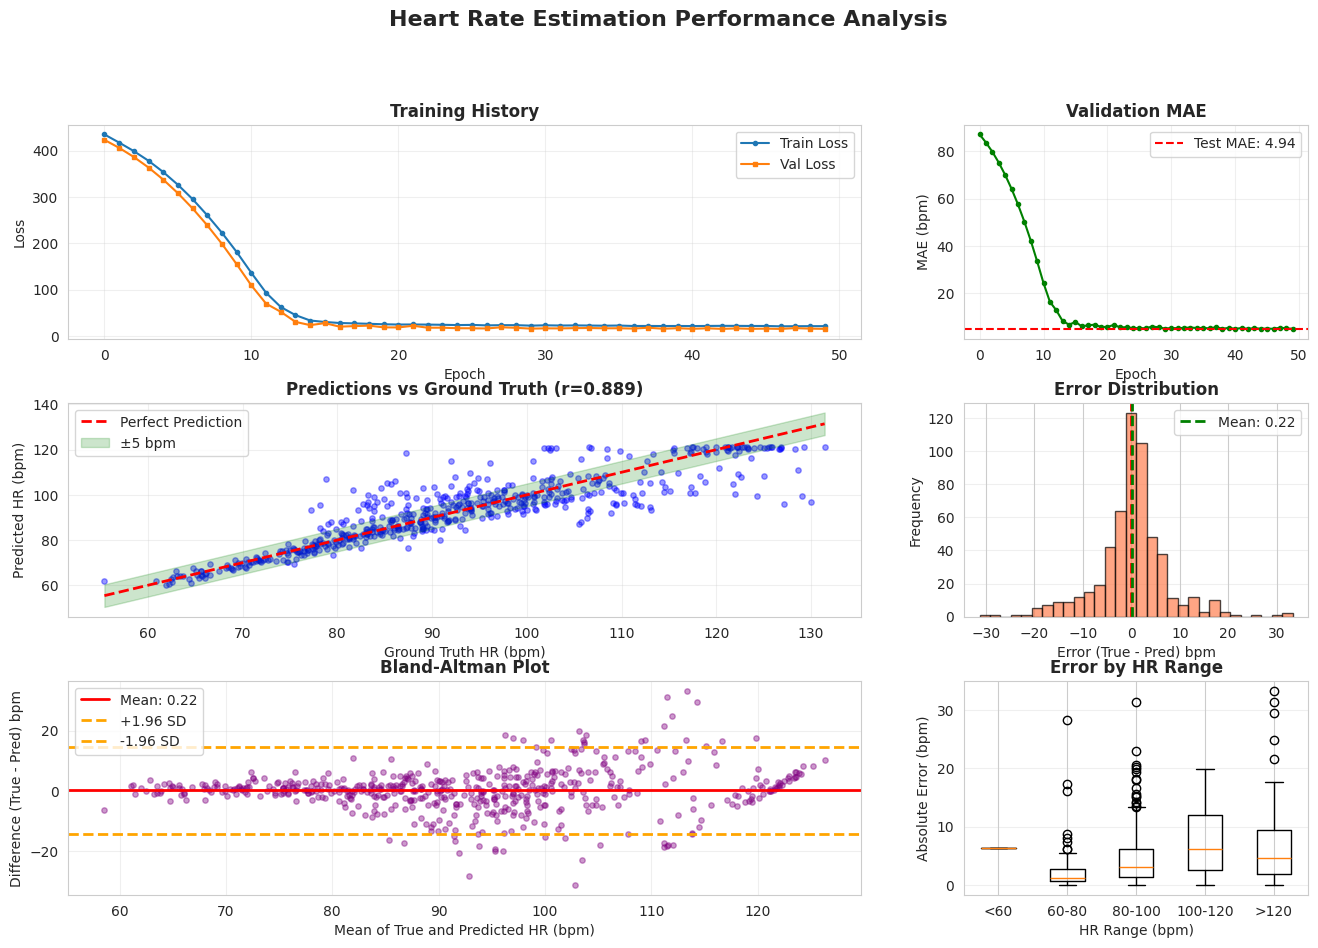

✓ Visualizations complete


In [ ]:

print("\n📊 GENERATING VISUALIZATIONS")
print("="*70)

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Training history
ax1 = fig.add_subplot(gs[0, :2])
ax1.plot(history['train_loss'], label='Train Loss', marker='o', markersize=3)
ax1.plot(history['val_loss'], label='Val Loss', marker='s', markersize=3)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training History', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# MAE progress
ax2 = fig.add_subplot(gs[0, 2])
ax2.plot(history['val_mae'], color='green', marker='o', markersize=3)
ax2.axhline(test_mae, color='red', linestyle='--', label=f'Test MAE: {test_mae:.2f}')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE (bpm)')
ax2.set_title('Validation MAE', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Scatter plot: Predictions vs Ground Truth
ax3 = fig.add_subplot(gs[1, :2])
ax3.scatter(test_trues, test_preds, alpha=0.4, s=15, color='blue')
min_val, max_val = test_trues.min(), test_trues.max()
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax3.fill_between([min_val, max_val], [min_val-5, max_val-5], [min_val+5, max_val+5],
                  alpha=0.2, color='green', label='±5 bpm')
ax3.set_xlabel('Ground Truth HR (bpm)')
ax3.set_ylabel('Predicted HR (bpm)')
ax3.set_title(f'Predictions vs Ground Truth (r={test_corr:.3f})', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Error distribution
ax4 = fig.add_subplot(gs[1, 2])
ax4.hist(errors, bins=30, edgecolor='black', alpha=0.7, color='coral')
ax4.axvline(0, color='red', linestyle='--', linewidth=2)
ax4.axvline(errors.mean(), color='green', linestyle='--', linewidth=2,
            label=f'Mean: {errors.mean():.2f}')
ax4.set_xlabel('Error (True - Pred) bpm')
ax4.set_ylabel('Frequency')
ax4.set_title('Error Distribution', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# Bland-Altman plot
ax5 = fig.add_subplot(gs[2, :2])
mean_vals = (test_trues + test_preds) / 2
diff_vals = test_trues - test_preds
ax5.scatter(mean_vals, diff_vals, alpha=0.4, s=15, color='purple')
ax5.axhline(diff_vals.mean(), color='red', linestyle='-', linewidth=2, label=f'Mean: {diff_vals.mean():.2f}')
ax5.axhline(diff_vals.mean() + 1.96*diff_vals.std(), color='orange', linestyle='--', linewidth=2, label='+1.96 SD')
ax5.axhline(diff_vals.mean() - 1.96*diff_vals.std(), color='orange', linestyle='--', linewidth=2, label='-1.96 SD')
ax5.set_xlabel('Mean of True and Predicted HR (bpm)')
ax5.set_ylabel('Difference (True - Pred) bpm')
ax5.set_title('Bland-Altman Plot', fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Absolute error distribution by HR range
ax6 = fig.add_subplot(gs[2, 2])
hr_ranges = pd.cut(test_trues, bins=[0, 60, 80, 100, 120, 200], labels=['<60', '60-80', '80-100', '100-120', '>120'])
abs_errors = np.abs(errors)
data_for_box = [abs_errors[hr_ranges == label] for label in ['<60', '60-80', '80-100', '100-120', '>120']]
ax6.boxplot(data_for_box, labels=['<60', '60-80', '80-100', '100-120', '>120'])
ax6.set_xlabel('HR Range (bpm)')
ax6.set_ylabel('Absolute Error (bpm)')
ax6.set_title('Error by HR Range', fontweight='bold')
ax6.grid(True, alpha=0.3, axis='y')

plt.suptitle('Heart Rate Estimation Performance Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.show()

print("✓ Visualizations complete")
print("="*70)

**REAL-WORLD INFERENCE FUNCTION**

In [ ]:

print("\n🔮 REAL-WORLD INFERENCE PIPELINE")
print("="*70)

def real_time_hr_estimation(raw_ppg, sampling_rate, model, preprocessor, device):
    """
    Real-time heart rate estimation from raw PPG signal

    Args:
        raw_ppg: Raw PPG signal (numpy array)
        sampling_rate: Sampling frequency in Hz
        model: Trained PyTorch model
        preprocessor: PPG preprocessor instance
        device: torch device

    Returns:
        estimated_hr: Estimated heart rate in bpm
        confidence: Confidence score (0-1)
    """

    try:
        # Preprocess
        ppg_processed = preprocessor.process(raw_ppg, sampling_rate)

        # Check if enough data (need 8 seconds at 125 Hz = 1000 samples)
        if len(ppg_processed) < 1000:
            return None, 0.0

        # Take last 1000 samples
        ppg_window = ppg_processed[-1000:]

        # Convert to tensor
        x = torch.from_numpy(ppg_window).float().unsqueeze(0).unsqueeze(0).to(device)

        # Inference
        model.eval()
        with torch.no_grad():
            hr_pred = model(x).item()

        # Calculate confidence based on signal quality
        quality = signal_quality_index(ppg_window)
        confidence = min(quality / 0.5, 1.0)  # Normalize to 0-1

        # Validate range
        if 40 <= hr_pred <= 180:
            return hr_pred, confidence
        else:
            return None, 0.0

    except Exception as e:
        print(f"Error in inference: {e}")
        return None, 0.0

# Demo inference on test sample
demo_sample = data_records[0]['ppg'][:int(data_records[0]['fs'] * 15)]  # 15 seconds
demo_fs = data_records[0]['fs']

estimated_hr, confidence = real_time_hr_estimation(demo_sample, demo_fs, model, preprocessor, device)

print(f"\n  Demo Inference:")
print(f"    Signal duration: {len(demo_sample)/demo_fs:.1f} seconds")
print(f"    Sampling rate: {demo_fs} Hz")
print(f"    Estimated HR: {estimated_hr:.1f} bpm")
print(f"    Confidence: {confidence:.2f}")
print("="*70)


🔮 REAL-WORLD INFERENCE PIPELINE

  Demo Inference:
    Signal duration: 15.0 seconds
    Sampling rate: 500 Hz
    Estimated HR: 97.2 bpm
    Confidence: 1.00


**SAVE MODEL AND RESULTS**

In [ ]:

print("\n💾 SAVING RESULTS")
print("="*70)

# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'test_mae': test_mae,
    'test_rmse': test_rmse,
    'test_corr': test_corr,
    'seq_len': seq_len
}, 'vit_ppg_hr_model_final.pth')

# Save results
results_df = pd.DataFrame({
    'true_hr': test_trues,
    'predicted_hr': test_preds,
    'absolute_error': np.abs(errors),
    'error': errors
})
results_df.to_csv('test_predictions.csv', index=False)

# Save metrics
metrics_summary = {
    'Test MAE': test_mae,
    'Test RMSE': test_rmse,
    'Pearson Correlation': test_corr,
    'Within ±5 bpm (%)': within_5,
    'Within ±10 bpm (%)': within_10,
    'Mean Error (Bias)': errors.mean(),
    'Error Std Dev': errors.std(),
    'Total Parameters': total_params,
    'Training Epochs': len(history['train_loss']),
    'Best Val MAE': best_val_mae
}

with open('model_metrics.txt', 'w') as f:
    for key, value in metrics_summary.items():
        f.write(f"{key}: {value}\n")

print("  ✓ Model saved: vit_ppg_hr_model_final.pth")
print("  ✓ Predictions saved: test_predictions.csv")
print("  ✓ Metrics saved: model_metrics.txt")
print("="*70)



💾 SAVING RESULTS
  ✓ Model saved: vit_ppg_hr_model_final.pth
  ✓ Predictions saved: test_predictions.csv
  ✓ Metrics saved: model_metrics.txt


**FINAL SUMMARY**

In [ ]:

print("\n" + "="*70)
print(" " * 20 + "🎉 PROJECT COMPLETE 🎉")
print("="*70)
print("\n📋 FINAL SUMMARY:")
print(f"  ✓ Dataset: {len(data_records)} records, {len(X_all):,} windows")
print(f"  ✓ Model: Vision Transformer with {total_params:,} parameters")
print(f"  ✓ Test MAE: {test_mae:.2f} bpm")
print(f"  ✓ Test RMSE: {test_rmse:.2f} bpm")
print(f"  ✓ Pearson Correlation: {test_corr:.4f}")
print(f"  ✓ Accuracy within ±5 bpm: {within_5:.1f}%")
print(f"  ✓ Accuracy within ±10 bpm: {within_10:.1f}%")
print("\n🚀 READY FOR REAL-WORLD DEPLOYMENT!")
print("="*70)


                    🎉 PROJECT COMPLETE 🎉

📋 FINAL SUMMARY:
  ✓ Dataset: 30 records, 3,669 windows
  ✓ Model: Vision Transformer with 812,161 parameters
  ✓ Test MAE: 4.94 bpm
  ✓ Test RMSE: 7.37 bpm
  ✓ Pearson Correlation: 0.8889
  ✓ Accuracy within ±5 bpm: 67.2%
  ✓ Accuracy within ±10 bpm: 84.6%

🚀 READY FOR REAL-WORLD DEPLOYMENT!
